In [1]:
import pandas as pd
import numpy as np
# from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.preprocessing import MinMaxScaler
# from joblib import dump, load

In [2]:
# 2. Đọc file csv và gắng index với giá Close
dxg = pd.read_csv('../DATA/DXG.csv')
qcg = pd.read_csv('../DATA/QCG.csv')
vhm = pd.read_csv('../DATA/VHM.csv')

def remove_commas_and_convert(x):
    return float(x.replace(',', ''))
# Áp dụng hàm cho toàn bộ DataFrame
dxg = dxg['Close'].apply(remove_commas_and_convert)
qcg = qcg['Close'].apply(remove_commas_and_convert)
vhm = vhm['Close'].apply(remove_commas_and_convert)

dxg1=dxg.reset_index()['Close']
qcg1=qcg.reset_index()['Close']
vhm1=vhm.reset_index()['Close']

In [3]:
dxg1

0       18450.0
1       18250.0
2       18050.0
3       18200.0
4       17850.0
         ...   
1247    17092.0
1248    17673.2
1249    17502.2
1250    17809.9
1251    17057.8
Name: Close, Length: 1252, dtype: float64

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))

dxg1=scaler.fit_transform(np.array(dxg1).reshape(-1,1))
qcg1=scaler.fit_transform(np.array(qcg1).reshape(-1,1))
vhm1=scaler.fit_transform(np.array(vhm1).reshape(-1,1))

In [5]:
# 4. Chia train test
#DXG
dxg_train_size = int(0.75 * len(dxg1))
dxg_test_size = int(0.15 * len(dxg1))
dxg_val_size = len(dxg1) - dxg_train_size - dxg_test_size
dxg_train_data = dxg1[:dxg_train_size]
dxg_test_data = dxg1[dxg_train_size:dxg_train_size+dxg_test_size]
dxg_val_data = dxg1[dxg_train_size+dxg_test_size:]

#QCG
qcg_train_size = int(0.75 * len(qcg1))
qcg_test_size = int(0.15 * len(qcg1))
qcg_val_size = len(qcg1) - qcg_train_size - qcg_test_size
qcg_train_data = qcg1[:qcg_train_size]
qcg_test_data = qcg1[qcg_train_size:qcg_train_size+qcg_test_size]
qcg_val_data = qcg1[qcg_train_size+qcg_test_size:]

#VHM
vhm_train_size = int(0.75 * len(vhm1))
vhm_test_size = int(0.15 * len(vhm1))
vhm_val_size = len(vhm1) - vhm_train_size - vhm_test_size
vhm_train_data = vhm1[:vhm_train_size]
vhm_test_data = vhm1[vhm_train_size:vhm_train_size+vhm_test_size]
vhm_val_data = vhm1[vhm_train_size+vhm_test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#DXG
time_step = 100
dxg_X_train, dxg_y_train = create_dataset(dxg_train_data, time_step)
dxg_X_val, dxg_yval = create_dataset(dxg_val_data, time_step)
dxg_X_test, dxg_ytest = create_dataset(dxg_test_data, time_step)

#QCG
qcg_X_train, qcg_y_train = create_dataset(qcg_train_data, time_step)
qcg_X_val, qcg_yval = create_dataset(qcg_val_data, time_step)
qcg_X_test, qcg_ytest = create_dataset(qcg_test_data, time_step)


#VHM
vhm_X_train, vhm_y_train = create_dataset(vhm_train_data, time_step)
vhm_X_val, vhm_yval = create_dataset(vhm_val_data, time_step)
vhm_X_test, vhm_ytest = create_dataset(vhm_test_data, time_step)

In [8]:
dxg_X_train.shape
qcg_X_train.shape
vhm_X_train.shape

(838, 100)

### RandomForest

In [9]:
dxg_model = RandomForestRegressor()
dxg_model.fit(dxg_X_train, dxg_y_train)

qcg_model = RandomForestRegressor()
qcg_model.fit(qcg_X_train, qcg_y_train)

vhm_model = RandomForestRegressor()
vhm_model.fit(vhm_X_train, vhm_y_train)

RandomForestRegressor()

In [10]:
dxg_train_predict = dxg_model.predict(dxg_X_train)
dxg_y_pred = dxg_model.predict(dxg_X_test)
dxg_y_pred_val = dxg_model.predict(dxg_X_val)

qcg_train_predict = qcg_model.predict(qcg_X_train)
qcg_y_pred = qcg_model.predict(qcg_X_test)
qcg_y_pred_val = qcg_model.predict(qcg_X_val)

vhm_train_predict = vhm_model.predict(vhm_X_train)
vhm_y_pred = vhm_model.predict(vhm_X_test)
vhm_y_pred_val = vhm_model.predict(vhm_X_val)

In [11]:
# 11. Dự báo giá cho 30 ngày tiếp theo
#DXG
x_input = dxg_val_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
dxg_lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = dxg_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        dxg_lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat =dxg_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        dxg_lst_output.extend(yhat.tolist())
        i += 1

dxg_lst_output = np.array(dxg_lst_output).reshape(-1, 1)

In [12]:
# 11. Dự báo giá cho 30 ngày tiếp theo
#QCG
x_input = qcg_val_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
qcg_lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = qcg_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        qcg_lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat =qcg_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        qcg_lst_output.extend(yhat.tolist())
        i += 1

qcg_lst_output = np.array(qcg_lst_output).reshape(-1, 1)

In [13]:
# 11. Dự báo giá cho 30 ngày tiếp theo
#VHM
x_input = vhm_val_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
vhm_lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = vhm_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        vhm_lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat =vhm_model.predict(x_input)
        temp_input.extend(yhat.tolist())
        vhm_lst_output.extend(yhat.tolist())
        i += 1

vhm_lst_output = np.array(vhm_lst_output).reshape(-1, 1)

NameError: name 'df1' is not defined

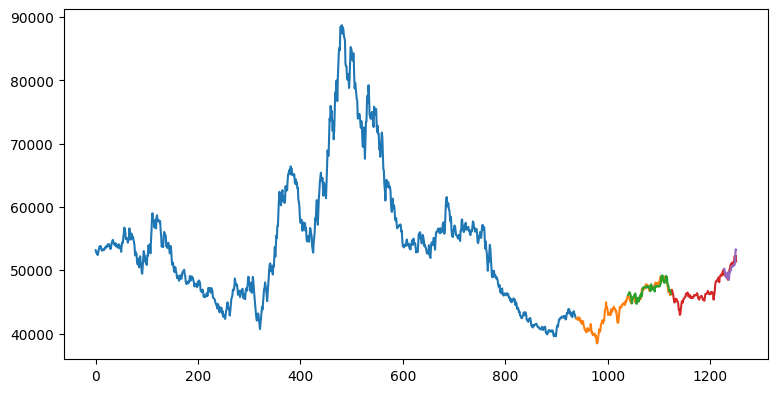

In [15]:
plt.figure(figsize=(20, 10))

#Random Forest
plt.subplot(2, 2, 1)    
dxg_train_data_index = pd.RangeIndex(start=0, stop=dxg_train_size, step=1)
plt.plot(scaler.inverse_transform(dxg_train_data))
dxg_test_data_index = pd.RangeIndex(start=dxg_train_size, stop=dxg_train_size+dxg_test_size, step=1)
plt.plot(dxg_test_data_index,scaler.inverse_transform(dxg_test_data))
dxg_test_data_index = pd.RangeIndex(start=dxg_train_size+101, stop=dxg_train_size+dxg_test_size, step=1)
plt.plot(dxg_test_data_index,scaler.inverse_transform(dxg_y_pred.reshape(-1,1)))
dxg_val_data_index = pd.RangeIndex(start=dxg_train_size+dxg_test_size, stop=dxg_train_size+dxg_test_size+dxg_val_size, step=1)
plt.plot(dxg_val_data_index,scaler.inverse_transform(dxg_val_data))
dxg_val_data_index = pd.RangeIndex(start=dxg_train_size+dxg_test_size+101, stop=dxg_train_size+dxg_test_size+dxg_val_size, step=1)
plt.plot(dxg_val_data_index,scaler.inverse_transform(dxg_y_pred_val.reshape(-1,1)))
dxg_prediect_data_index = pd.RangeIndex(start=len(dxg1)-1, stop=len(dxg1)+29, step=1)
plt.plot(dxg_prediect_data_index,scaler.inverse_transform(dxg_lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title("DXG")

plt.subplot(2, 2, 2)    
qcg_train_data_index = pd.RangeIndex(start=0, stop=qcg_train_size, step=1)
plt.plot(scaler.inverse_transform(qcg_train_data))
qcg_test_data_index = pd.RangeIndex(start=qcg_train_size, stop=qcg_train_size+qcg_test_size, step=1)
plt.plot(qcg_test_data_index,scaler.inverse_transform(qcg_test_data))
qcg_test_data_index = pd.RangeIndex(start=qcg_train_size+101, stop=qcg_train_size+qcg_test_size, step=1)
plt.plot(qcg_test_data_index,scaler.inverse_transform(qcg_y_pred.reshape(-1,1)))
qcg_val_data_index = pd.RangeIndex(start=qcg_train_size+qcg_test_size, stop=qcg_train_size+qcg_test_size+qcg_val_size, step=1)
plt.plot(qcg_val_data_index,scaler.inverse_transform(qcg_val_data))
qcg_val_data_index = pd.RangeIndex(start=qcg_train_size+qcg_test_size+101, stop=qcg_train_size+qcg_test_size+qcg_val_size, step=1)
plt.plot(qcg_val_data_index,scaler.inverse_transform(qcg_y_pred_val.reshape(-1,1)))
qcg_prediect_data_index = pd.RangeIndex(start=len(dxg1)-1, stop=len(dxg1)+29, step=1)
plt.plot(qcg_prediect_data_index,scaler.inverse_transform(qcg_lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title("QCG")

plt.subplot(2, 2, 3)    
vhm_train_data_index = pd.RangeIndex(start=0, stop=vhm_train_size, step=1)
plt.plot(scaler.inverse_transform(vhm_train_data))
vhm_test_data_index = pd.RangeIndex(start=vhm_train_size, stop=vhm_train_size+vhm_test_size, step=1)
plt.plot(vhm_test_data_index,scaler.inverse_transform(vhm_test_data))
vhm_test_data_index = pd.RangeIndex(start=vhm_train_size+101, stop=vhm_train_size+vhm_test_size, step=1)
plt.plot(vhm_test_data_index,scaler.inverse_transform(vhm_y_pred.reshape(-1,1)))
vhm_val_data_index = pd.RangeIndex(start=vhm_train_size+vhm_test_size, stop=vhm_train_size+vhm_test_size+vhm_val_size, step=1)
plt.plot(vhm_val_data_index,scaler.inverse_transform(vhm_val_data))
vhm_val_data_index = pd.RangeIndex(start=vhm_train_size+vhm_test_size+101, stop=vhm_train_size+vhm_test_size+vhm_val_size, step=1)
plt.plot(vhm_val_data_index,scaler.inverse_transform(vhm_y_pred_val.reshape(-1,1)))
vhm_prediect_data_index = pd.RangeIndex(start=len(vhm1)-1, stop=len(vhm1)+29, step=1)
plt.plot(vhm_prediect_data_index,scaler.inverse_transform(vhm_lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title("VHM")